In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import seaborn as sns
from scipy import stats

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1 Data Processing

##### a) Import the data from the website directly

In [2]:
adult_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header = None, skipinitialspace=True)


In [3]:
adult_df.sample(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
17838,23,Private,393248,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
23485,37,Private,243409,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,50,United-States,<=50K
3586,28,Private,50814,HS-grad,9,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K


##### b) Build column names for the dataframe

* age: continuous.
* workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
* fnlwgt: continuous.
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
* education-num: continuous.
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
* sex: Female, Male.
* capital-gain: continuous.
* capital-loss: continuous.
* hours-per-week: continuous.
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [4]:
list_of_columns = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", 
                   "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]
adult_df.columns = list_of_columns
adult_df.sample(3)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
32198,67,Self-emp-inc,182581,Some-college,10,Married-civ-spouse,Exec-managerial,Husband,White,Male,20051,0,20,United-States,>50K
3096,22,?,175586,HS-grad,9,Never-married,?,Unmarried,Black,Female,0,0,35,United-States,<=50K
15553,41,Private,166662,Prof-school,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,>50K


##### c) Check your dataframe shape to verify that you have the correct # of rows and columns

In [5]:
adult_df.shape

(32561, 15)

##### d) Drop the 3rd column from the data : fnlwgt

In [6]:
adult_df = adult_df.drop(['fnlwgt'], axis=1)
adult_df.shape

(32561, 14)

##### e) Making sure that the data has no true NA values

In [7]:
adult_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   education       32561 non-null  object
 3   education_num   32561 non-null  int64 
 4   marital_status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital_gain    32561 non-null  int64 
 10  capital_loss    32561 non-null  int64 
 11  hours_per_week  32561 non-null  int64 
 12  native_country  32561 non-null  object
 13  salary          32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


##### f) Use the .replace() method to make the following changes to the "salary" column

* "<=50K" should become 0
* ">50K" should become 1

In [8]:
adult_df["salary"] = adult_df["salary"].replace({"<=50K": 0, ">50K": 1})
adult_df.salary.value_counts()

salary
0    24720
1     7841
Name: count, dtype: int64

##### g) Create your X dataframe (just your predictors). It should include every feature except for the target variable which is "salary"

In [9]:
X = adult_df.drop('salary', axis=1)
X.shape

(32561, 13)

##### h) Create your y dataframe (just your target variable). It should only be "salary"

In [10]:
y = adult_df['salary'].to_numpy()
y.shape

(32561,)

##### i) For this homework we will try converting columns with factors to separate columns (i.e. one-hot encoding). It is not necessary for trees, but can be a very powerful tool to use. There are a variety of ways to do this, but we can use Pandas built-in method .get_dummies(). Pandas will automatically split out columns that are categorical. For now, just run across your full X dataframe.

In [11]:
X_encoded = pd.get_dummies(X)
X_encoded.shape

(32561, 107)

##### j) Split data into train / test set using an 70/30 split. Verify that you have the same number of columns in your X_train and X_test.

In [12]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

#verify if X_train and X_test have same number of columns
X_train.shape[1] == X_test.shape[1]

True

### 2 Random Forest Classifier - Base Model

##### a) Use the RandomForestClassifier in sklearn. Fit your model on the training data

In [13]:
# fit random forest classifier on training data
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier()

##### b) Use the fitted model to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes

In [14]:
# predict on test data
y_pred_rfc = rfc.predict(X_test)
y_pred_proba_rfc = rfc.predict_proba(X_test)

##### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics)

In [15]:
# calculate confusion matrix and classification report
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred_rfc))
print("\nClassification Report: \n", classification_report(y_test, y_pred_rfc))

Confusion Matrix: 
 [[6817  638]
 [ 868 1446]]

Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.91      0.90      7455
           1       0.69      0.62      0.66      2314

    accuracy                           0.85      9769
   macro avg       0.79      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



##### d) Calculate the AUC score

In [16]:
# calculate AUC score 
print("AUC Score: ",roc_auc_score(y_test, y_pred_proba_rfc[:, 1]))

AUC Score:  0.8898492076051817


##### e) Identify the top 5 features. Feel free to print a list OR to make a plot

Top 5 important features of Random Forest Classifier:  ['age' 'hours_per_week' 'capital_gain' 'education_num'
 'marital_status_Married-civ-spouse']


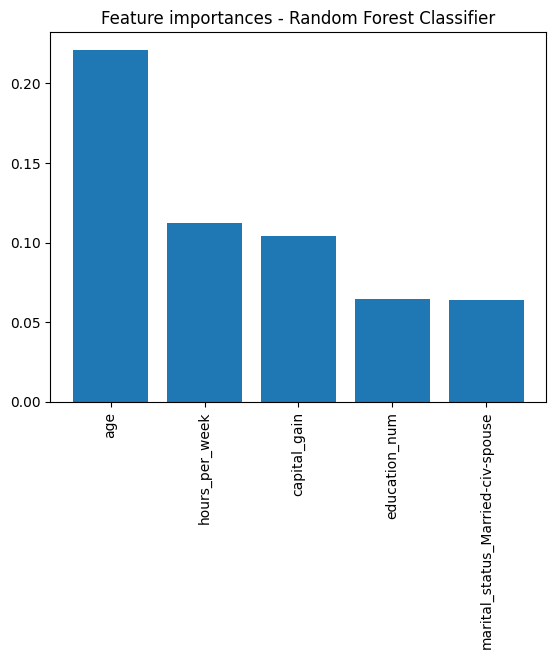

In [17]:
# identify top 5 features
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1][:5]
print("Top 5 important features of Random Forest Classifier: ", X_encoded.columns[indices].values)
plt.figure()
plt.title("Feature importances - Random Forest Classifier")
plt.bar(range(5), importances[indices])
plt.xticks(range(5), X_encoded.columns[indices], rotation=90)
plt.show()

##### f) Using the model from part B, predict for the train data. Look at the classification report for the train data - is there overfitting for the RandomForest model happening?

In [18]:
# predict for train data and calculate classification report
y_pred_train_rfc = rfc.predict(X_train)
print("Classification Report: \n", classification_report(y_train, y_pred_train_rfc))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99     17265
           1       0.97      0.95      0.96      5527

    accuracy                           0.98     22792
   macro avg       0.98      0.97      0.97     22792
weighted avg       0.98      0.98      0.98     22792



The classification report shows high precision, recall, and F1-score for both classes (0 and 1) on the train data. Based on the classification report on the test data, we can see that the precision, recall, and F1-score for class 1 are lower compared to class 0. This indicates that the model is not performing as well in predicting class 1 as it is in predicting class 0.

Furthermore, the accuracy on the test data is lower than the accuracy on the train data, which could be an indication of overfitting. The weighted average F1-score on the test data is also lower than the weighted average F1-score on the train data, which further suggests that there might be overfitting.

Therefore, based on the classification report on the test data, it is possible that there is overfitting in the RandomForest model. 

### 3 AdaBoost Classifier - GridSearch

##### a) Use the AdaBoostClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following:

n_estimators: 100, 200, 300, 400
learning_rate: 0.2,0.4,0.6,0.8,1, 1.2

Use 5 cross-fold and for scoring use "roc_auc" 

In [19]:
# create an AdaBoostClassifier with default parameters
abc = AdaBoostClassifier()

# define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300, 400],
              'learning_rate': [0.2, 0.4, 0.6, 0.8, 1, 1.2]}

##### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes

In [20]:
# create a GridSearchCV object with 5 cross-fold and roc_auc as scoring metric
grid_search = GridSearchCV(abc, param_grid, cv=5, scoring='roc_auc',n_jobs=-1)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters found by GridSearchCV
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'learning_rate': 1.2, 'n_estimators': 400}


In [21]:
# get the best estimator found by GridSearchCV
best_clf_abc = grid_search.best_estimator_

# use the best estimator to predict on the test data
y_pred_abc = best_clf_abc.predict(X_test) # predicted classes
y_pred_proba_abc = best_clf_abc.predict_proba(X_test)[:, 1] # predicted probabilities

##### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics)

In [22]:
# calculate confusion matrix and classification report
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_abc))
print("Classification report:")
print(classification_report(y_test, y_pred_abc))

Confusion matrix:
[[7008  447]
 [ 807 1507]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.77      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



##### d) Calculate the AUC score

In [23]:
# calculate AUC score
print("AUC score:", roc_auc_score(y_test, y_pred_proba_abc))

AUC score: 0.9244122180504519


##### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

Top 5 important features of AdaBoost Classifier:  ['capital_gain' 'capital_loss' 'age' 'hours_per_week' 'education_num']


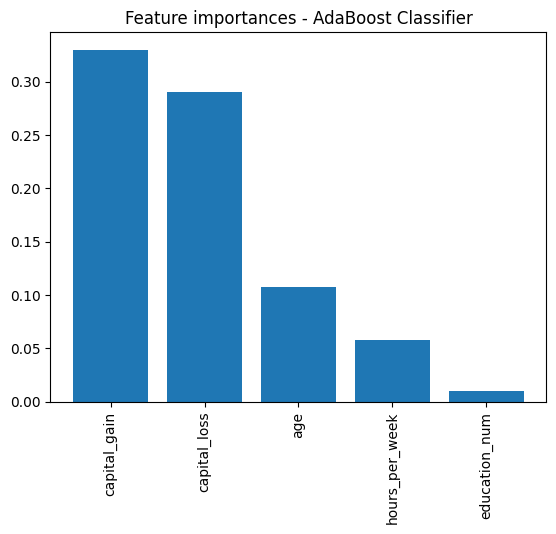

In [24]:
# identify top 5 features
importances = best_clf_abc.feature_importances_
indices = np.argsort(importances)[::-1][:5]
print("Top 5 important features of AdaBoost Classifier: ", X_encoded.columns[indices].values)
plt.figure()
plt.title("Feature importances - AdaBoost Classifier")
plt.bar(range(5), importances[indices])
plt.xticks(range(5), X_encoded.columns[indices], rotation=90)
plt.show()

##### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [25]:
# predict for the train data using the best estimator and calculate classification report
y_pred_train_abc = best_clf_abc.predict(X_train) 
print("Classification Report: \n", classification_report(y_train, y_pred_train_abc))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     17265
           1       0.78      0.66      0.71      5527

    accuracy                           0.87     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.87      0.87     22792



The difference in performance metrics between the train and test data is not significant, and the accuracy, macro avg, and weighted avg F1-score are similar for both datasets. This indicates that the best estimator in Adaboost is not overfitting the train data and is generalizing well to the test data.

### 4 Gradient Boosting Classifier - GridSearch

##### a) Use GradientBoostingClassifier along with the GridSearchCV tool. Run the GridSearchCV using the following hyperparameters:

n_estimators: 100,200, 300 & 400
learning_rate: choose 3 learning rates of your choice
max_depth: 1, 2 

Use 5 cross-fold and for scoring use "roc_auc"

In [26]:
# create a GradientBoostingClassifier object
gbc = GradientBoostingClassifier()

# define the parameter grid to search over
param_grid = {'n_estimators': [100, 200, 300, 400],
              'learning_rate': [0.05, 0.1, 0.2],
              'max_depth': [1, 2]}

##### b) Use the best estimator from GridSearchCV to predict on test data. Use the .predict_proba() and the .predict() methods to get predicted probabilities as well as predicted classes

In [27]:
# create a GridSearchCV object with 5 cross-fold and roc_auc as scoring metric
grid_search = GridSearchCV(gbc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# print the best parameters found by GridSearchCV
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 400}


In [28]:
# get the best estimator found by GridSearchCV
best_clf_gbc = grid_search.best_estimator_

# use the best estimator to predict on the test data
y_pred_gbc = best_clf_gbc.predict(X_test) # predicted classes
y_pred_proba_gbc = best_clf_gbc.predict_proba(X_test)[:, 1] # predicted probabilities


##### c) Calculate the confusion matrix and classification report (both are in sklearn.metrics)

In [29]:
# calculate confusion matrix and classification report
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_gbc))
print("Classification report:")
print(classification_report(y_test, y_pred_gbc))

Confusion matrix:
[[7030  425]
 [ 814 1500]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



##### d) Calculate the AUC score

In [30]:
# calculate AUC score
print("AUC score:", roc_auc_score(y_test, y_pred_proba_gbc))

AUC score: 0.9259131568436837


##### e) Identify the top 5 features. Feel free to print a list OR to make a plot.

Top 5 important features of Gradient Boosting Classifier:  ['marital_status_Married-civ-spouse' 'capital_gain' 'education_num'
 'capital_loss' 'age']


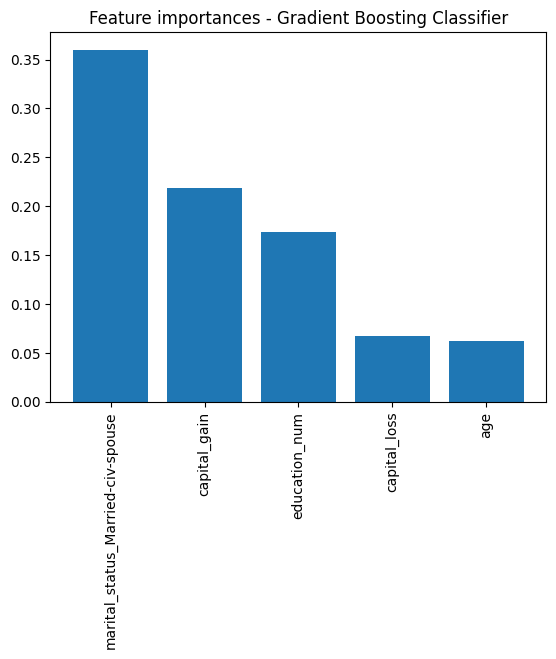

In [31]:
# identify top 5 features
importances = best_clf_gbc.feature_importances_
indices = np.argsort(importances)[::-1][:5]
print("Top 5 important features of Gradient Boosting Classifier: ", X_encoded.columns[indices].values)
plt.figure()
plt.title("Feature importances - Gradient Boosting Classifier")
plt.bar(range(5), importances[indices])
plt.xticks(range(5), X_encoded.columns[indices], rotation=90)
plt.show()

##### f) Using the model from part (b), predict for the train data. Look at the classification report for the train data - is there overfitting for the best estimator?

In [32]:
# predict for the train data using the best estimator and calculate classification report
y_pred_train_gbc = best_clf_gbc.predict(X_train) 
print("Classification Report: \n", classification_report(y_train, y_pred_train_gbc))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92     17265
           1       0.81      0.67      0.73      5527

    accuracy                           0.88     22792
   macro avg       0.85      0.81      0.83     22792
weighted avg       0.88      0.88      0.88     22792



Looking at the classification reports for the train and test data, we can see that the precision, recall, and F1-score for both classes (0 and 1) are slightly lower on the test data compared to the train data. However, the difference in performance metrics between the train and test data is not significant, and the accuracy, macro avg, and weighted avg F1-score are similar for both datasets. This indicates that the best estimator in Gradient Boosting with Gridsearch is not overfitting the train data and is generalizing well to the test data.

### 5 XGBoost - RandomizedSearchCV

In [35]:
# create XGB classifier
xgb_clf = xgb.XGBClassifier(n_jobs=os.cpu_count(),random_state=42)

# define the parameter grid
param_grid = {
    'n_estimators': np.arange(100, 1050, 50),
    'learning_rate': np.arange(0.1, 1.7, 0.1),
    'max_depth': [1, 2],
    'gamma': np.arange(0, 5.25, 0.25)
}

# create RandomizedSearchCV object
rs_cv = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, cv=5, n_iter=50, scoring='roc_auc', n_jobs=os.cpu_count(), random_state=42)

# fit the model on the train data
rs_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                   param_distributions={'gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
                                        'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6]),
                                        'max_depth': [1, 2],
                                        'n_estimators': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000])},
                   random_state=42, scoring='roc_auc')

Best parameters:  {'n_estimators': 600, 'max_depth': 1, 'learning_rate': 1.3000000000000003, 'gamma': 0.0}

Confusion matrix:
[[7023  432]
 [ 817 1497]]
Classification report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7455
           1       0.78      0.65      0.71      2314

    accuracy                           0.87      9769
   macro avg       0.84      0.79      0.81      9769
weighted avg       0.87      0.87      0.87      9769


AUC score: 0.9258622608598871

Top 5 important features of XGBoost Classifier:  ['marital_status_Married-civ-spouse' 'education_num' 'education_Bachelors'
 'occupation_Exec-managerial' 'occupation_Farming-fishing']


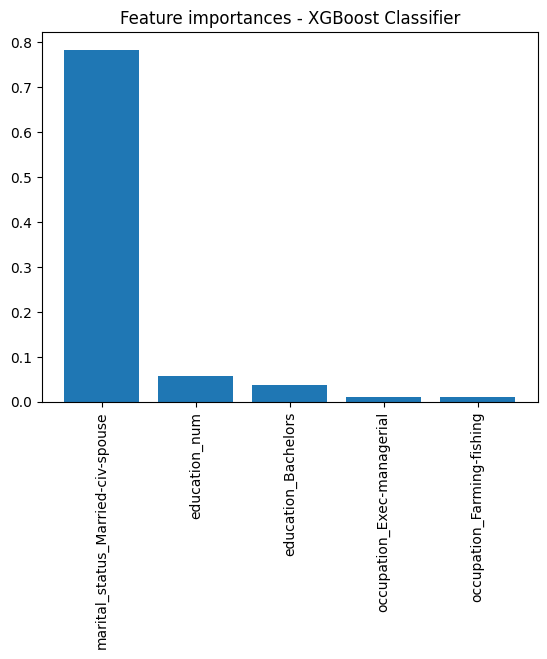

In [36]:
# print the best parameters found by RandomizedSearchCV
print("Best parameters: ", rs_cv.best_params_)

# get the best estimator
xgb_best = rs_cv.best_estimator_

# predict on the test data
y_pred_xgb = xgb_best.predict(X_test)
y_pred_proba_xgb = xgb_best.predict_proba(X_test)

# calculate confusion matrix and classification report
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("Classification report:")
print(classification_report(y_test, y_pred_xgb))

# calculate AUC score
print("\nAUC score:", roc_auc_score(y_test, y_pred_proba_xgb[:, 1]))

# identify top 5 features
importances = xgb_best.feature_importances_
indices = np.argsort(importances)[::-1][:5]
print("\nTop 5 important features of XGBoost Classifier: ", X_encoded.columns[indices].values)
plt.figure()
plt.title("Feature importances - XGBoost Classifier")
plt.bar(range(5), importances[indices])
plt.xticks(range(5), X_encoded.columns[indices], rotation=90)
plt.show()

In [37]:
# predict for the train data using the best estimator and calculate classification report
y_pred_train_xgb = xgb_best.predict(X_train) 
print("Classification Report: \n", classification_report(y_train, y_pred_train_xgb))

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92     17265
           1       0.79      0.66      0.72      5527

    accuracy                           0.88     22792
   macro avg       0.84      0.80      0.82     22792
weighted avg       0.87      0.88      0.87     22792



Though we can see that the  model is performing slightly better on the train data compared to the test data, the difference in performance between the train and test data is not very large, which suggests that the overfitting is not severe.

### 6 Conceptual Problems


<i>a) The lecture notes describe the Gini Index which is the default criterion used for splitting in sklearn's version of RandomForestClassifier. How does the Gini Index work? (i.e. How is it used to build a top-performing model?). </i>

The <b>Gini index</b> is a measure of impurity used in decision trees and random forests. It measures the degree or probability of a particular feature being wrongly classified when it is randomly chosen. The Gini index ranges from 0 to 1, where 0 indicates that all samples belong to the same class, and 1 indicates that the classes are equally distributed. In the context of decision trees and random forests, the Gini index is used to determine the best split at each node. When selecting a split point, the algorithm calculates the Gini index for each feature and selects the feature that results in the lowest Gini index. This means that the feature with the smallest Gini index is considered to be the most informative feature for splitting the data.

<br>

<i>b) Describe how Random Forest is different from bagging & why this difference can yield improved results.</i>

<b>Random Forest</b> is an extension of bagging that introduces two modifications: feature randomness and subspace sampling. Feature randomness selects a random subset of features at each split of a decision tree, and subspace sampling selects a random subset of features for each tree. These modifications <b>increase the diversity of the ensemble and reduce correlation between the trees, which can lead to improved accuracy and stability of predictions.</b> Whereas, <b>Bagging</b> creates subsets of the training data and trains decision trees on each subset, but does not include feature randomness or subspace sampling.

<br>

<i>c) Describe the importance of the max_depth parameter in Random Forest. Do not just provide a definition, rather think through how bias-variance tradeoff might be impacted by the max_depth parameter.</i>

The <b>max_depth parameter</b> in Random Forest is important for balancing the bias-variance tradeoff and can impact the performance of the model. Setting max_depth too high can lead to overfitting, as the trees can become too complex and memorize the noise in the training data, resulting in a model with high variance and low bias, which may perform well on the training data but poorly on unseen data. On the other hand, setting max_depth too low can lead to underfitting, as the trees may be too simple to capture the patterns in the data, resulting in a model with low variance and high bias, which may perform poorly on both the training and test data. The optimal max_depth value will depend on the specific dataset and problem at hand, and can be determined using techniques such as cross-validation or grid search. It is important to choose an appropriate value for max_depth to avoid overfitting or underfitting.

<br>

<i>d) What does the alpha parameter represent in AdaBoost? Please refer to chapter 7 of the Hands-On ML book if you are struggling.</i>

In AdaBoost, <b>the alpha parameter</b> represents the contribution weight of each individual model in the ensemble based on its accuracy on the training data, i.e., how much influence each stump will have in the final classification. These alpha values are used to weigh the contribution of each stump in the ensemble when making predictions for new instances. 

The alpha value is calculated as follows:

* The training error of the weak classifier is calculated as the sum of the weights of the incorrectly classified training examples divided by the total weight of all the training examples.

* The alpha value is then calculated as a function of the training error. The formula for the alpha value is:  <b>alpha = 0.5 * ln((1 - training error) / training error),</b>  where ln is the natural logarithm.

* The weight of each weak classifier is then updated based on its alpha value. The weight is multiplied by e^(alpha) if the classifier correctly classifies a training example, and by e^(-alpha) if the classifier incorrectly classifies a training example.

Stumps with higher alpha values contribute more to the final prediction of the ensemble, while stumps with lower alpha values contribute less.

<br>

<i>e) In AdaBoost explain how the final predicted class is determined. Be sure to reference the alpha term in your explanation.</i>

When making predictions, the final prediction of the AdaBoost ensemble is determined by <b>the weighted average of the predictions of all the individual models, with each model's contribution weighted by its alpha value.</b> The alpha values determine the contribution of each weak classifier to the final prediction. Models with higher alpha values have a greater influence on the final prediction, while models with lower alpha values have a smaller influence. The idea behind AdaBoost is that by assigning higher weights to the more accurate weak classifiers, they will have a larger influence on the final prediction, resulting in a better classification performance.

<br>

<i>f) In Gradient Boosting, what is the role of the max_depth parameter? Why is it important to tune on this parameter?</i>

In Gradient Boosting, <b>the max_depth parameter</b> specifies the maximum depth of each decision tree in the ensemble. The max_depth parameter is important because it controls the complexity of the decision trees, which can have a significant impact on the performance of the model. Specifically, increasing the value of max_depth can lead to overfitting, where the model becomes too complex and fits the training data too closely, resulting in poor generalization to new, unseen data. On the other hand, setting max_depth too low can result in underfitting, where the model is too simple and fails to capture important patterns in the data.

Therefore, it is important to tune the max_depth parameter to find the optimal value that balances between overfitting and underfitting. This can be done by evaluating the model's performance on a validation set or using cross-validation. By trying different values of max_depth and selecting the one that results in the best performance on the validation set, we can ensure that the model generalizes well to new data.

<br>

<i>g) In Part (e) of Steps 2-5 you determined the top 5 predictors across each model. Do any predictors show up in the top 5 predictors for all three models? If so, comment on if this predictor makes sense given what you are attempting to predict. (Note: If you don't have any predictors showing up across all 3 predictors, explain one that shows up in 2 of them).</i>

We can notice that the <b>age, education_num and capital_gain</b> predictors show up in the top 5 predictors for most of our models and it definitely makes sense as these features help in predicting whether an individual has an income that exceeds $50K.

<br>

<i>h) From the models run in steps 2-5, which performs the best based on the Classification Report? Support your reasoning with evidence from your test data and be sure to share the optimal hyperparameters found from your grid search.</i>

On comparing the Classification Report, we can see that Gradient Boosting and XGBoost have nearly the same results but we can conclude that the <b>Gradient Boosting model is the best</b> cus it has a higher AUC score. Also the optimal hyperparamters for XGBoost indicate that the model has a relatively small tree depth, a high learning rate, and a large number of trees to ensemble. This suggests that the model could be overfitting to the training data. However, for <b>Gradient Boosting</b>, the best hyperparameters are <b>learning_rate=0.2, max_depth=2, and n_estimators=400.</b> These hyperparameters suggest that the model has a moderate learning rate and tree depth, and a large number of trees to ensemble. This implies that the model may not be overfitting to the training data and may be more robust to unseen data.

<b>Gradient Boosting</b> is be a better model due to its moderate hyperparameters that suggest a balance between overfitting and underfitting and the highest AUC score.

<br>

<i>i) For your best performing model, plot out a ROC curve using your test data. Feel free to use sklearn, matplotlib or any other method in python. Describe what the x-axis & y-axis of the ROC curve tell us about a classifier.</i>

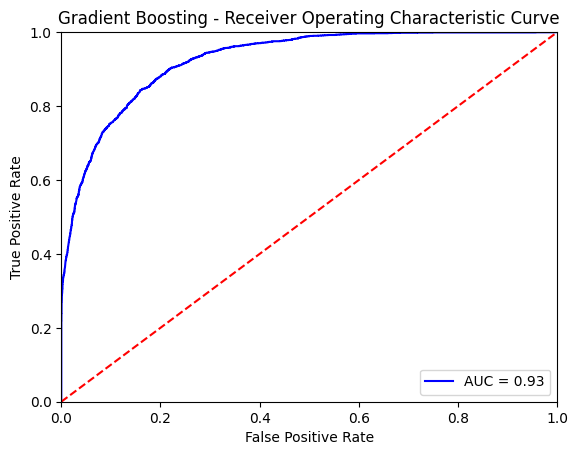

In [38]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_proba_gbc)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Gradient Boosting - Receiver Operating Characteristic Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The <b>Receiver Operating Characteristic (ROC) curve</b> is a graphical representation of the performance of a binary classifier, which is a model that predicts the class of an instance as either positive or negative. The ROC curve is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

* The <b>x-axis</b> of the ROC curve represents the <b>False Positive Rate (FPR),</b> which is the proportion of negative instances that are incorrectly classified as positive by the classifier.
* The <b>y-axis</b> of the ROC curve represents the <b>True Positive Rate (TPR),</b> which is the proportion of positive instances that are correctly classified as positive by the classifier.

A good classifier is the one that has a high TPR and a low FPR, which means that it can accurately detect positive instances while avoiding false alarms. The optimal classifier would have a TPR of 1 (i.e., all positive instances are correctly classified) and an FPR of 0 (i.e., no negative instances are incorrectly classified as positive). The area under the curve (AUC) can be used as a summary measure of the classifier's performance, where a <b>higher AUC indicates a better classifier.</b>